In [4]:
from datasets import load_dataset, concatenate_datasets

digits = load_dataset("ernestchu/emnist-digits")


In [5]:
from PIL import Image
import numpy as np
from io import BytesIO

def emnist_map(batch, dtype="float32", normalize=True, flatten=True, orient_fix=False):
    """
    Chuyển batch['image'] -> batch['x'] (numpy) và giữ batch['label'].
    - dtype: "float32" (train trực tiếp) hoặc "uint8" (tiết kiệm RAM; scale sau).
    - normalize: nếu True và dtype=float32 -> chia 255.0.
    - flatten: nếu True -> (N, 784); nếu False -> (N, 28, 28).
    - orient_fix: xoay + lật để sửa hướng EMNIST nếu cần.
    """
    xs = []
    for im in batch["image"]:
        # chấp nhận PIL.Image hoặc dict {'bytes'|'path'|'array'}
        if isinstance(im, Image.Image):
            pil = im.convert("L")
        elif isinstance(im, dict):
            if im.get("bytes", None) is not None:
                b = im["bytes"]
                if not isinstance(b, (bytes, bytearray)):
                    b = bytes(b)
                pil = Image.open(BytesIO(b)).convert("L")
            elif im.get("path", None):
                pil = Image.open(im["path"]).convert("L")
            elif im.get("array", None) is not None:
                pil = Image.fromarray(np.array(im["array"]).astype(np.uint8), mode="L")
            else:
                raise ValueError(f"Unsupported image dict keys: {list(im.keys())}")
        else:
            # fallback: numpy array
            pil = Image.fromarray(np.array(im).astype(np.uint8), mode="L")

        if orient_fix:
            pil = pil.rotate(-90, expand=True).transpose(Image.FLIP_LEFT_RIGHT)

        arr = np.array(pil)  # (28,28), uint8
        if not flatten:
            x = arr.astype(np.float32) if dtype == "float32" else arr.astype(np.uint8)
        else:
            x = arr.reshape(-1).astype(np.float32) if dtype == "float32" else arr.reshape(-1).astype(np.uint8)

        if dtype == "float32" and normalize:
            x /= 255.0

        xs.append(x)

    return {"x": np.stack(xs), "label": np.array(batch["label"], dtype=np.int64)}


In [6]:
from datasets import DatasetDict
import numpy as np

# 1) Tải và CẮT theo mỗi label
def sample_per_label(dataset, label_col="label", k=1000, seed=42):
    y = np.array(dataset[label_col])
    uniq = np.unique(y)
    rng = np.random.default_rng(seed)
    idx = []
    for u in uniq:
        ids = np.where(y == u)[0]
        take = min(k, len(ids))
        if take > 0:
            idx.append(rng.choice(ids, size=take, replace=False))
    idx = np.sort(np.concatenate(idx)).tolist() if idx else []
    return dataset.select(idx)

train_small = sample_per_label(digits["train"], k=1000, seed=42)
test_small  = sample_per_label(digits["test"],  k=200, seed=42)
ds_small = DatasetDict({"train": train_small, "test": test_small})

print("Original:", len(digits["train"]), len(digits["test"]))
print("Subset  :", len(ds_small["train"]), len(ds_small["test"]))

# 2) MAP trên BỘ ĐÃ CẮT 
ds_proc = ds_small.map(
    emnist_map,                      # hàm ánh xạ bạn đã viết
    batched=True,
    remove_columns=["image"],
    fn_kwargs={"dtype":"uint8", "normalize":False, "flatten":True, "orient_fix":False},
    num_proc=1,
    load_from_cache_file=False       # tránh dùng lại cache cũ
)

# 3) Lấy NumPy để train (nhẹ RAM)
import numpy as np
X_train = np.stack(ds_proc["train"]["x"]).astype("float32") / 255.0
y_train = np.asarray(ds_proc["train"]["label"], dtype="int64")
X_test  = np.stack(ds_proc["test"]["x"]).astype("float32") / 255.0
y_test  = np.asarray(ds_proc["test"]["label"], dtype="int64")

# sanity check
assert ds_proc["train"].num_rows == len(ds_small["train"])
assert ds_proc["test"].num_rows == len(ds_small["test"])


Original: 240000 40000
Subset  : 10000 2000


Map: 20000 examples [00:00, 12474.81 examples/s]         
Map: 4000 examples [00:00, 13053.88 examples/s]        


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
import pickle

X_train = np.stack(ds_proc["train"]["x"]).astype("float32")   # (n_train, 784)
y_train = np.asarray(ds_proc["train"]["label"], dtype="int64")# (n_train,)

X_test  = np.stack(ds_proc["test"]["x"]).astype("float32")
y_test  = np.asarray(ds_proc["test"]["label"], dtype="int64")

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty='l2', random_state=42, solver='saga', max_iter=1000))
])

param_grid = {
    'logreg__C':[0.001, 0.01, 0.1, 1, 10],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_log_loss',
    cv=cv,
    n_jobs=-1,
    refit=True, 
    return_train_score=True
)

grid.fit(X_train, y_train)

with open("logreg-digits.pkl", "wb") as f:
    pickle.dump(grid, f)


d:\Code\Python\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [8]:
print("best param: ", grid.best_params_)
y_pred = grid.best_estimator_.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))

best param:  {'logreg__C': 0.01}
Accuracy:  0.9325


In [9]:
with open("logreg-digits.pkl", "rb") as f:
    loaded_model = pickle.load(f)

y_proba = loaded_model.best_estimator_.predict_proba(X_test)
y_proba = np.asarray(y_proba)

In [ ]:
import math
import numpy as np
import pandas as pd

# ---------- Ranking metrics (per-query) ----------

def dcg_at_k(gains, k):
    gains = np.asarray(gains)[:k]
    if gains.size == 0:
        return 0.0
    discounts = 1.0 / np.log2(np.arange(2, gains.size + 2))
    return float(np.sum((2.0 ** gains - 1.0) * discounts))

def ndcg_at_k(labels_ranked, k):
    labels_ranked = np.asarray(labels_ranked)
    dcg = dcg_at_k(labels_ranked, k)
    ideal = dcg_at_k(np.sort(labels_ranked)[::-1], k)
    return float(dcg / ideal) if ideal > 0 else 0.0

def mrr_at_k(labels_ranked, k):
    for i, g in enumerate(labels_ranked[:k]):
        if g > 0:
            return 1.0 / float(i + 1)
    return 0.0

def precision_at_k(labels_ranked, k):
    if k <= 0:
        return 0.0
    topk = np.asarray(labels_ranked[:k])
    return float(np.sum(topk > 0)) / float(k)

def eval_query_k(k, y_true, y_proba, K=10):
    # Scores to rank by = probability of class k
    scores = y_proba[:, k]
    order = np.argsort(-scores)  # descending
    rel = (y_true == k).astype(int)
    labels_ranked = rel[order].tolist()
    return {
        f"NDCG@{K}": ndcg_at_k(labels_ranked, K),
        f"MRR@{K}": mrr_at_k(labels_ranked, K),
        f"P@{K}": precision_at_k(labels_ranked, K),
        "relevant_total": int(rel.sum()),
    }

rows = []
n_classes = y_proba.shape[1]
for k in range(n_classes):
    rows.append({"query": k, **eval_query_k(k, y_test, y_proba, K=10)})
df_metrics = pd.DataFrame(rows)
df_metrics

,query,NDCG@10,MRR@10,P@10,relevant_total
0,0,1.0,1.0,1.0,200
1,1,1.0,1.0,1.0,200
2,2,1.0,1.0,1.0,200
3,3,1.0,1.0,1.0,200
4,4,1.0,1.0,1.0,200
5,5,1.0,1.0,1.0,200
6,6,1.0,1.0,1.0,200
7,7,1.0,1.0,1.0,200
8,8,1.0,1.0,1.0,200
9,9,1.0,1.0,1.0,200


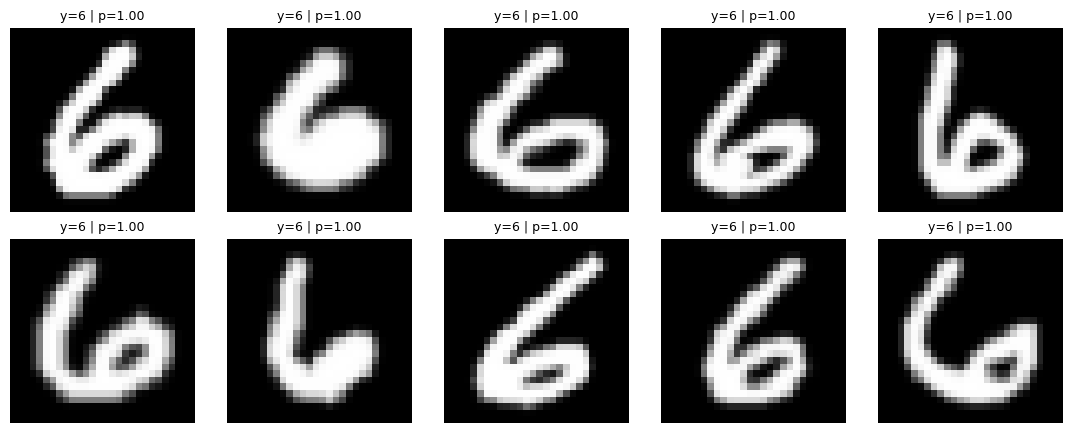

In [16]:
import matplotlib.pyplot as plt

k = 6  # 0 -> 9
rel = (y_test == k).astype(int)
scores = y_proba[:, k]
order = np.argsort(-scores)
topK = order[:10]

cols = 5
rows = int(np.ceil(10/cols))
plt.figure(figsize=(cols*2.2, rows*2.2))
for i, idx in enumerate(topK, 1):
    plt.subplot(rows, cols, i)
    plt.imshow(X_test[idx].reshape(28,28), cmap="gray")
    plt.title(f"y={y_test[idx]} | p={scores[idx]:.2f}", fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()